In [1]:
!pip install yfinance
!pip install mplfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Simulate some data (replace this with your actual data loading logic)
np.random.seed(42)
num_assets = 4
num_portfolios = 10000
returns = np.random.randn(num_assets, 250) * 0.01  # Simulated daily returns

# Calculate mean returns and covariance matrix
mean_returns = returns.mean(axis=1)
cov_matrix = np.cov(returns)

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std_dev, returns

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def optimize_portfolio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(negative_sharpe_ratio, weights, args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

init_guess = num_assets * [1. / num_assets,]
opt_result = optimize_portfolio(init_guess, mean_returns, cov_matrix)
opt_weights = opt_result.x

# Print optimized weights
print("Optimized Portfolio Weights:", opt_weights)


In [2]:
import yfinance
# from yahoofinancials import YahooFinancials
import mplfinance as mpf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn  as sns
from plotly import express as px
import datetime as dt
import os
# -----------------------------------------
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
#-------------------------------------------
sns.set()

In [3]:
stocknames = ['MSFT','AAPL', 'SPY', 'GLD', 'BTC-USD', '^N225', 'CL=F'] # You can change them as you wish
startdate = '2019-01-01'
enddate =   dt.datetime.now().date()
# enddate = '2019-12-31'
interval = '1d'

In [4]:
import yfinance as yf

In [5]:
data = yf.download("AAPL", start="2021-01-01", end="2021-12-31")

[*********************100%%**********************]  1 of 1 completed


In [6]:
!pip install pandas-datareader

In [7]:
from pandas_datareader import data

In [8]:
import pandas_datareader as pdr
import yfinance as yf

stocknames = ['MSFT', 'AAPL', 'SPY', 'GLD', 'BTC-USD', '^N225', 'CL=F']  
startdate = '2019-01-01'
enddate = '2022-12-31'

for stock in stocknames:
    df = yf.download(stock, start=startdate, end=enddate)
    df.to_csv('{}.csv'.format(stock))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
def appending(cols=[], startdate = '', enddate = ''):
    '''append stocks data into one file and then select the Adj Close column'''
    global df
    dates = pd.date_range(start= startdate, end= enddate)
    df = pd.DataFrame(index= dates)
    for stock in stocknames:
        df_symbols = pd.read_csv(os.path.join('{}.csv'.format(stock)), index_col='Date', parse_dates=True, usecols=cols, na_values=['NaN'])
        df_symbols = df_symbols.rename(columns={'Adj Close' : stock})
        df = df.join(df_symbols)
        df = df.loc[dates]
    df = df.dropna()
    return df

In [10]:
appending(['Date', 'Adj Close'], startdate, enddate)
df.index.names = ['Date']
df.head()

,MSFT,AAPL,SPY,GLD,BTC-USD,^N225,CL=F
Date,,,,,,,
2019-01-04,96.61,35.53,231.87,121.44,"3,857.72","19,561.96",47.96
2019-01-07,96.74,35.45,233.70,121.86,"4,025.25","20,038.97",48.52
2019-01-08,97.44,36.13,235.90,121.53,"4,030.85","20,204.04",49.78
2019-01-09,98.83,36.74,237.00,122.31,"4,035.30","20,427.06",52.36
2019-01-10,98.20,36.86,237.84,121.59,"3,678.92","20,163.80",52.59


In [11]:
df = df.rename(columns={'BTC-USD' : 'BTC', '^N225' : 'JPN', 'CL=F' : 'OIL'})
df.head()

,MSFT,AAPL,SPY,GLD,BTC,JPN,OIL
Date,,,,,,,
2019-01-04,96.61,35.53,231.87,121.44,"3,857.72","19,561.96",47.96
2019-01-07,96.74,35.45,233.70,121.86,"4,025.25","20,038.97",48.52
2019-01-08,97.44,36.13,235.90,121.53,"4,030.85","20,204.04",49.78
2019-01-09,98.83,36.74,237.00,122.31,"4,035.30","20,427.06",52.36
2019-01-10,98.20,36.86,237.84,121.59,"3,678.92","20,163.80",52.59


In [12]:
daily_returns = df.pct_change().dropna()

In [13]:
!pip install PyPortfolioOpt

In [14]:
from pypfopt import HRPOpt
# run the optimization algorithm to get the weights:
hrp = HRPOpt(daily_returns)
hrp_weights = hrp.optimize()

# performance of the portfolio and the weights:
hrp.portfolio_performance(verbose=True)
hrp_weights = dict(hrp_weights)
print(hrp_weights)

Expected annual return: 13.5%
Annual volatility: 12.7%
Sharpe Ratio: 0.90
{'AAPL': 0.05477173997307412, 'BTC': 0.011969369028738158, 'GLD': 0.4973090186342554, 'JPN': 0.30827104412172485, 'MSFT': 0.04191664870398151, 'OIL': 0.0039761879679835865, 'SPY': 0.08178599157024234}


In [15]:
sum(hrp_weights.values())

1.0

In [16]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(df)
da_hrp = DiscreteAllocation(hrp_weights, latest_prices, total_portfolio_value=10000)

allocation, leftover = da_hrp.greedy_portfolio()
print("Discrete allocation (HRP):", allocation)
print("Funds remaining (HRP): ${:.2f}".format(leftover))

Discrete allocation (HRP): {'GLD': 29, 'SPY': 2, 'AAPL': 4, 'MSFT': 2, 'OIL': 1}
Funds remaining (HRP): $3258.39


In [17]:
from pypfopt.efficient_frontier import EfficientCVaR
from pypfopt.expected_returns import mean_historical_return

mu= mean_historical_return(df)
S = df.cov()
ef_cvar = EfficientCVaR(mu, S)
cvar_weights = ef_cvar.min_cvar()

cleaned_weights = ef_cvar.clean_weights()
print(dict(cleaned_weights))
round(np.mean(ef_cvar.expected_returns) *100,2)

{'MSFT': 0.0, 'AAPL': 0.0, 'SPY': 0.0, 'GLD': 0.0, 'BTC': 1.0, 'JPN': 0.0, 'OIL': 0.0}


C:\Users\HARSH\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


23.26

In [18]:
np.seterr(invalid= 'ignore')
da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

Discrete allocation (CVAR): {'MSFT': 1}
Funds remaining (CVAR): $9762.73


In [19]:
# Yearly returns for individual companies
ind_er = df.resample('Y').last().pct_change().mean()
ind_er.to_frame()

,0
MSFT,0.23
AAPL,0.31
SPY,0.10
GLD,0.07
BTC,0.98
JPN,0.04
OIL,0.14


In [20]:
# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(252))
ann_sd

MSFT   0.32
AAPL   0.35
SPY    0.23
GLD    0.16
BTC    0.76
JPN    0.21
OIL    0.62
dtype: float64

In [21]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
MSFT,0.23,0.32
AAPL,0.31,0.35
SPY,0.10,0.23
GLD,0.07,0.16
BTC,0.98,0.76
JPN,0.04,0.21
OIL,0.14,0.62


In [22]:

p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df.columns)
num_portfolios = 10000

# Log of percentage change
cov_matrix = daily_returns.cov()

In [23]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [24]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]
portfolios  = pd.DataFrame(data)

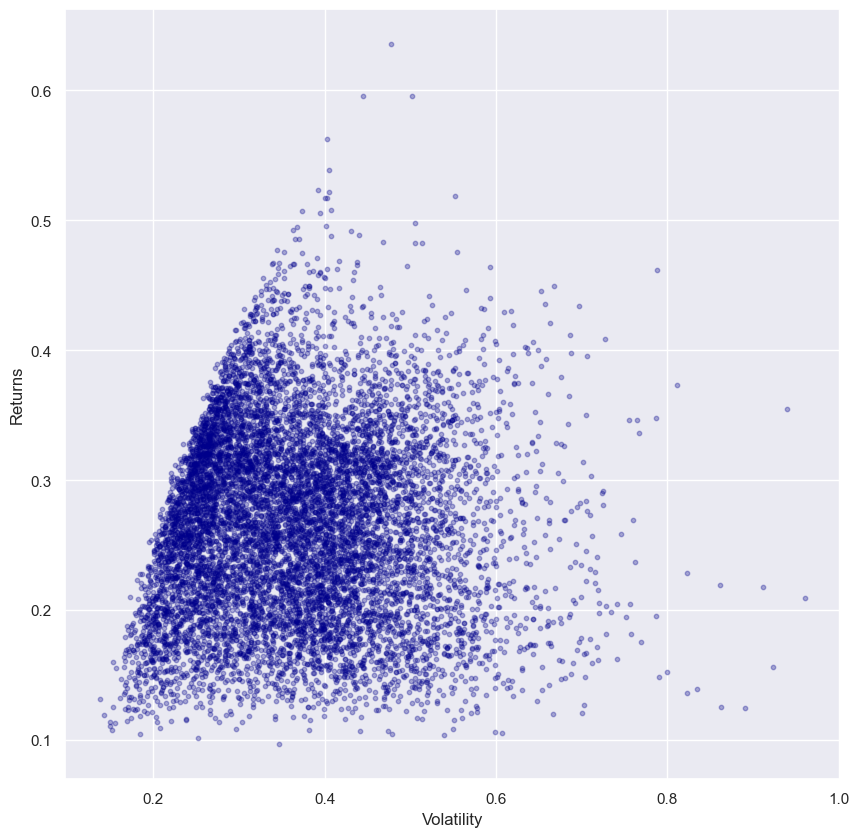

In [26]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Returns       0.13
Volatility    0.14
MSFT weight   0.00
AAPL weight   0.20
SPY weight    0.03
GLD weight    0.45
BTC weight    0.03
JPN weight    0.29
OIL weight    0.00
Name: 9916, dtype: float64

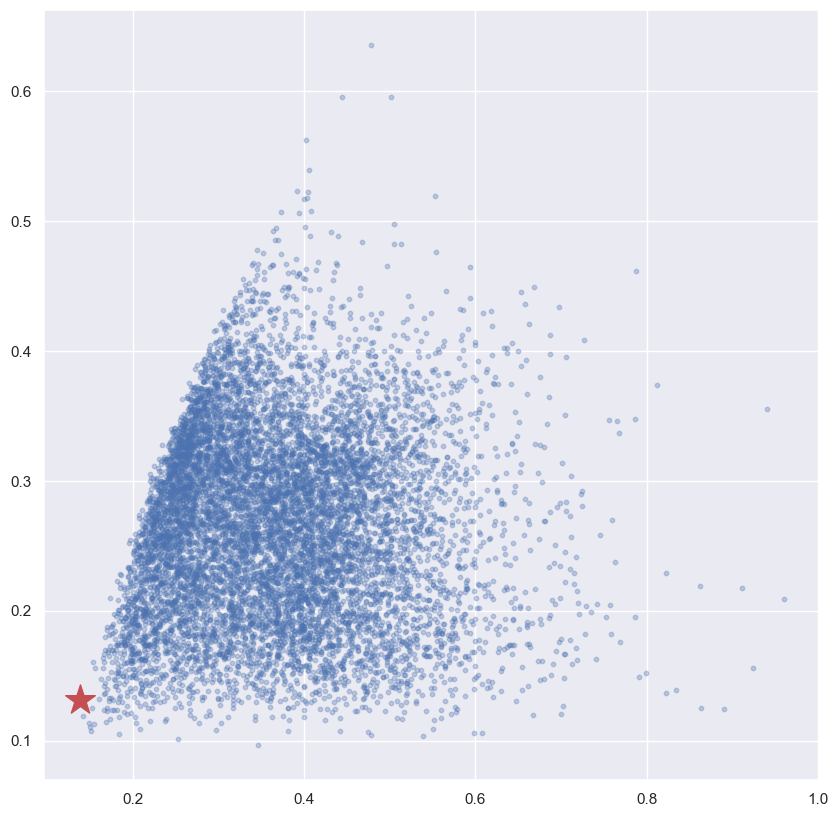

In [28]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns       0.39
Volatility    0.27
MSFT weight   0.06
AAPL weight   0.25
SPY weight    0.01
GLD weight    0.28
BTC weight    0.28
JPN weight    0.11
OIL weight    0.02
Name: 3387, dtype: float64

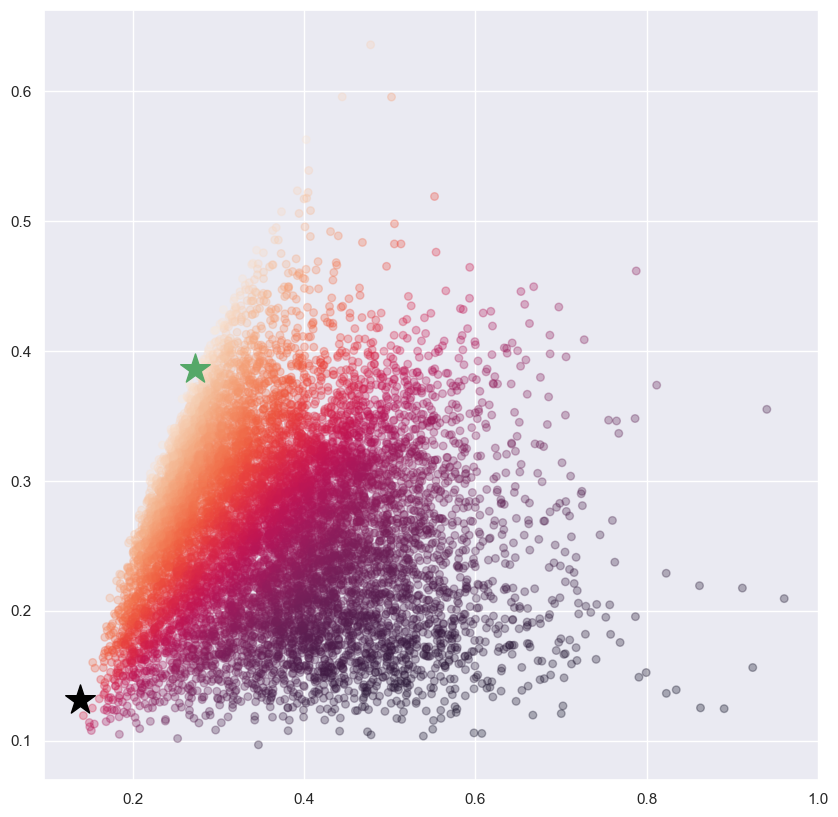

In [31]:
returns = df/df.shift(1)
years = 3
cagr = (df.iloc[-1]/df.iloc[0])**(1/years) - 1
cov = returns.cov()
print(cagr)


MSFT   0.35
AAPL   0.54
SPY    0.17
GLD    0.12
BTC    0.63
JPN    0.10
OIL    0.19
dtype: float64


      MSFT  AAPL  SPY  GLD  BTC  JPN  OIL
MSFT  0.00  0.00 0.00 0.00 0.00 0.00 0.00
AAPL  0.00  0.00 0.00 0.00 0.00 0.00 0.00
SPY   0.00  0.00 0.00 0.00 0.00 0.00 0.00
GLD   0.00  0.00 0.00 0.00 0.00 0.00 0.00
BTC   0.00  0.00 0.00 0.00 0.00 0.00 0.00
JPN   0.00  0.00 0.00 0.00 0.00 0.00 0.00
OIL   0.00  0.00 0.00 0.00 0.00 0.00 0.01


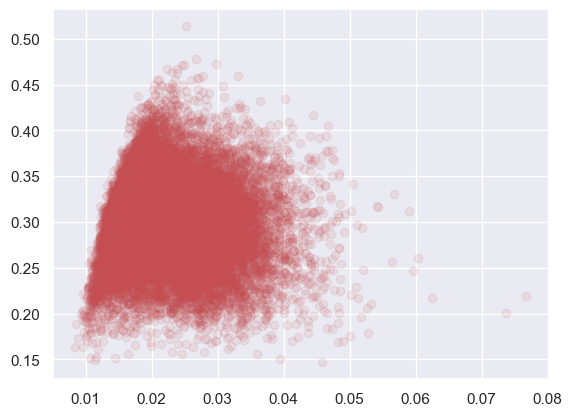

In [33]:
def random_weights(n):
    k = np.random.rand(n)
    return k / sum(k)
exp_return = []
sigma = []
